# 01_Data_Visualization_Teste

## TL;DR
Fazer uma descrição de 3 linhas do objetivo do notebook e conclusões presentes na análise.

## Objetivo

Descrever com clareza qual o objetivo desse notebook.

## Dados

Descrever a base de dados utilizada.

## Modelos (opcional)

Em caso de treinamento ou comparação de modelos, descrever os modelos considerados

## Conclusões
Listar **todas** as conclusões obtidas no notebook:
1. conclusão 1
2. conclusão 2
3. etc.


## Observações importantes:
1. Sempre organize o conteúdo utilizando células markdown e seções. Também utilize células de texto para escrever sua análise das figuras que forem geradas.
2. Lembre-se que essa primeira célula deve ter informação suficiente para entender o que foi feito e quais conclusões você chegou, sem ter que ler o notebook inteiro. Isso agiliza muito a busca por informações ao longo do projeto. Além disso, seu eu do futuro (ou novas pessoas que entrem no projeto) vai agradecer se o seu notebook estiver bem escrito e completo.

# Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw


C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Importando Dataset

In [2]:
# Caminho da pasta onde estão as subpastas dos voluntários
root_dir = "../../data/data_cluster"  # Altere para o caminho correto do seu sistema

# Configuração de estilo dos gráficos
sns.set(style="whitegrid")

# Importando Bibliotecas para Visualização de Dados

In [3]:
def carregar_dados(root_dir):
    """
    Lê todos os arquivos .csv de subpastas e retorna um DataFrame consolidado.
    """
    all_data = []
    for voluntario in os.listdir(root_dir):
        pasta = os.path.join(root_dir, voluntario)
        if os.path.isdir(pasta):
            for arquivo in os.listdir(pasta):
                if arquivo.endswith('.csv'):
                    caminho_arquivo = os.path.join(pasta, arquivo)
                    try:
                        df = pd.read_csv(caminho_arquivo)
                        df['voluntario'] = voluntario
                        all_data.append(df)
                    except Exception as e:
                        print(f"Erro ao ler {caminho_arquivo}: {e}")
    return pd.concat(all_data, ignore_index=True)

dados = carregar_dados(root_dir)

print(f"Total de amostras carregadas: {dados.shape[0]}")
dados.head()

Total de amostras carregadas: 25931


,626.6068,-0.078125,1.129883,0.1328125,3.71875,-9.46875,-1.34375,-0.2080078,-0.01171875,0.8037109,...,0.8925781,0.9853516,-0.1113281,2.59375,191.2656,93.42404,260.6633,145.1859,289.9967,257.6203
0,626.6403,-0.078125,1.129883,0.132812,3.71875,-9.46875,-1.34375,-0.208008,-0.011719,0.803711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,626.6739,-0.078125,1.129883,0.132812,3.71875,-9.46875,-1.34375,-0.208008,-0.011719,0.803711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,626.7075,-0.061523,1.046875,-0.089844,-1.25000,-13.03125,-6.37500,-0.208008,-0.011719,0.803711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,626.7408,-0.061523,1.046875,-0.089844,-1.25000,-13.03125,-6.37500,-0.208008,-0.011719,0.803711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,626.7742,-0.061523,1.046875,-0.089844,-1.25000,-13.03125,-6.37500,-0.208008,-0.011719,0.803711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Colunas selecionadas para análise:
Index(['191.2656', '93.42404', '260.6633', '145.1859', '289.9967', '257.6203'], dtype='object')


C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Yama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Yama\AppData\Local\Temp\ipykernel_17468\2327968013.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dados['cluster_dtw'] = clusters_dtw


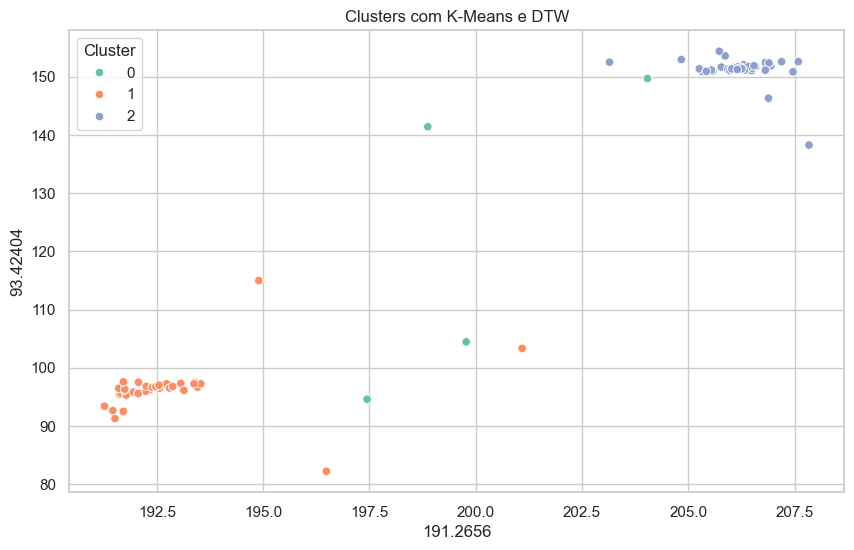

In [5]:
# Selecionar as últimas 6 colunas numéricas
colunas_numericas = dados.select_dtypes(include=np.number).columns
ultimas_colunas = colunas_numericas[-6:]
print("Colunas selecionadas para análise:")
print(ultimas_colunas)

# Filtrar apenas essas colunas
dados_numericos = dados[ultimas_colunas]

# Tratar valores ausentes (substituir pela média)
dados_numericos = dados_numericos.fillna(dados_numericos.mean())

# Converter os dados para o formato de séries temporais (3D)
dados_temporais = dados_numericos.values.reshape(dados_numericos.shape[0], dados_numericos.shape[1], 1)

# Aplicar K-Means com DTW
kmeans_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
clusters_dtw = kmeans_dtw.fit_predict(dados_temporais)

# Adicionar os clusters ao DataFrame original
dados['cluster_dtw'] = clusters_dtw

# Visualizar os resultados com um gráfico de dispersão por clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=dados[ultimas_colunas[0]],
    y=dados[ultimas_colunas[1]],
    hue=dados['cluster_dtw'],
    palette='Set2',
    legend='full'
)
plt.title("Clusters com K-Means e DTW")
plt.xlabel(ultimas_colunas[0])
plt.ylabel(ultimas_colunas[1])
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Conclusões

Aqui você deve listar todas as conclusões obtidas ao longo do notebook.
Pode copiar todo o conteúdo dessa seção lá na parte de conclusões do cabeçalho.